## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

In [102]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)


In [103]:

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

FileNotFoundError: [WinError 2] The system cannot find the file specified

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

I have been unable to get the prewritten code to work, at all.  "The system cannot find the file specified."  Perusing the (extensive) documentation to the subprocess module has been ineffective.  I'd like to resolve this; nevertheless, I can open the .dot file using LibreOffice, and can see the cell contents from which I can infer the tree.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [176]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor


# I came to realize I would need this.
import random

In [177]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [106]:
df.shape

(2218, 18)

In [178]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [179]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [180]:
# These data are from 2020, yes?
df['n_age'] = 2020 - df['birth_year']

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [181]:
df.isna().sum()

patient_id               0
global_num             904
sex                    145
birth_year             454
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64

There are a LOT of missing values here!  It looks like several important variables only have a handful of values.

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [183]:
df['disease'].fillna(0, inplace=True)
df['disease'].replace({True: 1}, inplace=True)
df['disease'].value_counts()

0    2199
1      19
Name: disease, dtype: int64

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [184]:
# Some of these MIGHT make sense to impute with the mean...  but 'infected_by'?  Possibly some others too.
# It would be nice to have a data dictionary here.

#df[['global_num', 'birth_year', 'infection_order', 'infected_by', 'contact_number']].fillna(df.mean(), inplace=True)
# the above code produced a "SettingWithCopyWarning": "A value is trying to be set on a copy of a slice from a DF"
# I went and read about this a bit, and the problem here remains opaque to me.  No NA's got filled.

# Trying them one by one:
imputed = ['global_num', 'birth_year', 'infection_order', 'infected_by', 'contact_number']
for imp in imputed:
    df[imp].fillna(df[imp].mean(), inplace=True)

In [185]:
df.isna().sum()

patient_id               0
global_num               0
sex                    145
birth_year               0
age                    261
country                  0
province                 0
city                    65
disease                  0
infection_case        1055
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

Well, first of all, since we got n_age by arithmetic on birth_year, we should use the same imputation method for n_age.  And if for n_age, why not age? 

In [186]:
df['n_age'].fillna(df['n_age'].mean(), inplace=True)


In [187]:
df.dtypes


patient_id              int64
global_num            float64
sex                    object
birth_year            float64
age                    object
country                object
province               object
city                   object
disease                 int64
infection_case         object
infection_order       float64
infected_by           float64
contact_number        float64
symptom_onset_date     object
confirmed_date         object
released_date          object
deceased_date          object
state                  object
n_age                 float64
dtype: object

The remaining columns with null values are: 'sex', 'age', 'city', 'infection_case', 'symptom_onset_date', 'confirmed_date', 'released_date', 'deceased_date', 'state', all of which are dtype 'object'.  I'll examine them:

In [188]:
obj_columns = ['sex', 'age', 'city', 'infection_case', 'symptom_onset_date', 'confirmed_date', 'released_date', 'deceased_date', 'state']
for col in obj_columns:
    print(col, "\n", df[col].value_counts())

sex 
 female    1171
male       902
Name: sex, dtype: int64
age 
 20s     467
50s     385
40s     303
30s     251
60s     229
70s     117
80s      84
10s      74
0s       29
90s      17
100s      1
Name: age, dtype: int64
city 
 Gyeongsan-si    535
Cheonan-si       98
Seongnam-si      89
Bonghwa-gun      60
Gumi-si          59
               ... 
Gyeryong-si       1
Hanam-si          1
Gunsan-si         1
Namhae-gun        1
Guri-si           1
Name: city, Length: 134, dtype: int64
infection_case 
 contact with patient                530
etc                                 220
Guro-gu Call Center                 102
Shincheonji Church                   86
overseas inflow                      61
Onchun Church                        33
gym facility in Cheonan              30
Ministry of Oceans and Fisheries     27
Cheongdo Daenam Hospital             21
Dongan Church                        17
Eunpyeong St. Mary's Hospital        14
Seongdong-gu APT                     13
gym facility in 

These variables are all unlike and need to be considered distinctly.  The 'sex' variable admits only two values.  I could replace missing values with the mode - but the existing data are pretty close to equal.  Calling all of the missing values 'female' seems like it's going to distort our analysis. I'm going to attempt to randomly assign 'male' and 'female' in proportion to the ratio among the non-null cases: 

In [189]:
nnfemale, nnmale = 1171, 902
# there are 145 missing values for 'sex' (see above)
nsex = 145
nfemale = int(round((nsex * (nnfemale / (nnfemale + nnmale))),0))
nmale = int(round((nsex * (nnmale / (nnfemale + nnmale))), 0))
print("Imputed females:", nfemale, "\nImputed males:", nmale)

Imputed females: 82 
Imputed males: 63


In [190]:
# All right, those actually sum to 145!  (I thought int() would round??) Now I want to randomly assign 82 'female' and 63 'male'
# observations to the missing values in the 'sex' column.
impute_shuffle = []
for i in range(nfemale):
    impute_shuffle.append('female')
for i in range(nmale):
    impute_shuffle.append('male')
random.shuffle(impute_shuffle)

In [191]:
# Now I've got to apply these to the missing values.  
# df['sex'].fillna(impute_shuffle) - I should have known this would fail, but I thought it was worth a try...
for i in range(len(df['sex'])):
    if df['sex'].isna()[i] == True:
        df['sex'][i] = impute_shuffle.pop()

# if this works correctly the impute_shuffle list should be completely empty...
print(impute_shuffle)

C:\Users\null\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[]


In [192]:
# Well, impute_shuffle is now an empty list.  But I got a warning. Does df['sex'] have any missing values?
df['sex'].isna().sum()

0

Perhaps this seems like a lot of work for just one imputation, but I feel a lot better about this than any of the simpler alternatives.  There are many suggestions online to select the mode for imputation of a categorical variable, but - in particular, for such an important variable as sex, and in a case where there's close to an even split - I don't think that's sound.  I would have thought that there would be a way like this to fill na's in some or other module, but I can't find any documentation of any such thing.  Maybe this will be useful for some of the other variables; who knows?

Perhaps this seems like a lot of work for just one imputation, but I feel a lot better about this than any of the simpler alternatives.  There are many suggestions online to select the mode for imputation of a categorical variable, but - in particular, for such an important variable as sex, and in a case where there's close to an even split - I don't think that's sound.  I would have thought that there would be a way like this to fill na's in some or other module, but I can't find any documentation of any such thing.  Maybe this will be useful for some of the other variables; who knows?

The next variable remaining with nulls is 'age' - as represented by decade of life.  We do have an 'n_age' column, calculated from birth year.  Still, perhaps this could prove useful - whether as a means to check the overall integrity (by comparing with n_age) or as a set of ready-made categories.  I'm going to drop the trailing 's', convert to integers, and then add 5 to get the midpoint of each age range.

In [193]:
df['age'] = df['age'].str.strip('s')
df['age'] = pd.to_numeric(df['age'])
df['age'] = df['age'] + 5

It appears that the interpreter doesn't want to allow me to convert this to type 'int' while it still has null values; I'll impute the null values and then convert.

In [199]:
df['age'].mean()

45.50076647930506

Perhaps this is a bit dodgy, but this value being so close to 45 makes me want to just call it 45.  And since we imputed 'n_age' with the mean, it makes sense to do the same thing to this age range variable.  Although it's kind of bizarre to have both of them.

In [201]:
df['age'].fillna(45, inplace=True)

The next variable with null values is 'city' - here, I am tempted to be lazy and just use the mode.  However, why not see if I can generalize my random sampling method for imputing gender?  Or maybe there's already a method in a module that does this?  There's got to be.

(spent some time searching)

And yet I can't find it.  However, I can see that there are far easier ways to implement the method I used above for 'sex'.  

In [230]:
resampler = list(df['city'].sample(65))

for i in range(len(df['city'])):
    if df['city'].isna()[i] == True:
        df['city'][i] = resampler.pop()
        
# check: resampler should be an empty list
print(resampler)

C:\Users\null\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


['Suwon-si', 'Goyang-si', 'Gwacheon-si', 'Gyeongju-si', 'Gyeongsan-si', 'Gyeryong-si', 'Chilgok-gun', 'Gyeongsan-si', 'Pohang-si', 'Anyang-si', 'Dongdaemun-gu', 'Andong-si', 'Changwon-si', 'Gyeongsan-si', 'Wonju-si', 'Gyeongsan-si', 'Gumi-si', 'Seongnam-si', 'Bonghwa-gun', 'Eunpyeong-gu', 'Gyeongsan-si', 'Gyeongsan-si', 'Gyeongsan-si', 'Gyeongsan-si', 'Gyeongsan-si', 'Geoje-si', 'Cheongdo-gun', 'Gyeongsan-si', 'Chilgok-gun', 'Cheonan-si', 'Gyeongsan-si', 'Songpa-gu', 'Uiseong-gun', 'Sejong', 'Seongnam-si', 'etc', 'Gunsan-si', 'Bonghwa-gun', 'Bonghwa-gun', 'Gyeongsan-si', 'Nam-gu', 'Gyeongsan-si', 'Seocho-gu', 'Gyeongsan-si', 'Nowon-gu', 'Uijeongbu-si', 'Cheongdo-gun', 'Nam-gu', 'etc', 'Gimpo-si', 'Seongju-gun', 'Cheonan-si', 'Sejong', 'Mapo-gu', 'Mapo-gu', 'Gangseo-gu', 'Gangseo-gu', 'Pohang-si', 'Gyeongsan-si', 'Changwon-si', 'Pohang-si', 'Andong-si', 'Bucheon-si', 'Gangseo-gu']


In [232]:
# let's see what's remaining to impute:
df.isna().sum()

patient_id               0
global_num               0
sex                      0
birth_year               0
age                      0
country                  0
province                 0
city                     0
disease                  0
infection_case        1055
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                    0
dtype: int64

In [239]:
# I'm going to try to make a function that does this:
def SRSImputer(data, column):
    n = data[column].isna().sum()
    imputed_values = data[column].sample(n)
    for i in range(len(data[column])):
        if data[column].isna()[i] == True:
            data[column][i] = imputed_values.pop(-1)

# I'm leaving out the date columns for now because there are a lot of missing values and date perhaps should be handled 
# differently...

last_columns = ['infection_case', 'state']
for column in last_columns:
        SRSImputer(df, column)

KeyError: -1

In [240]:
# well, that failed spectacularly!!  Let's see where we're at:
df.isna().sum()

patient_id               0
global_num               0
sex                      0
birth_year               0
age                      0
country                  0
province                 0
city                     0
disease                  0
infection_case        1054
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                    0
dtype: int64

In [249]:
# This is curious, and I'd like to fix whatever's wrong with that function later, but for now I'll do them manually:

impute = list(df['infection_case'].loc[df['infection_case'].notna() == True].sample(1054))
print(impute[0:20])

['contact with patient', 'etc', 'contact with patient', 'Ministry of Oceans and Fisheries', 'etc', 'overseas inflow', 'Seongdong-gu APT', 'Shincheonji Church', 'Guro-gu Call Center', 'contact with patient', 'Guro-gu Call Center', 'overseas inflow', 'contact with patient', 'etc', 'Shincheonji Church', 'Guro-gu Call Center', 'Guro-gu Call Center', 'Shincheonji Church', 'contact with patient', 'contact with patient']


In [251]:
for i in range(len(df['infection_case'])):
    if df['infection_case'].isna()[i] == True:
        df['infection_case'][i] = impute.pop()
print(impute)

C:\Users\null\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[]


In [252]:
impute = list(df['state'].loc[df['state'].notna() == True].sample(88))
for i in range(len(df['state'])):
    if df['state'].isna()[i] == True:
        df['state'][i] = impute.pop()
print(impute)

C:\Users\null\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[]


Now I come to the problem of the date values.  I'm going to cop out because, having read ahead a little, I see that the date columns are going to get dropped a few cells down anyway.  This is also a bigger problem - if I impute using the random sampling method I employed above, I'm going to introduce outright contradictory values into the data.  I'm not sure of the best method to impute for these values.

 **<font color='teal'> Check for any remaining null values.</font>**

In [253]:
df.isna().sum()

patient_id               0
global_num               0
sex                      0
birth_year               0
age                      0
country                  0
province                 0
city                     0
disease                  0
infection_case           0
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                    0
n_age                    0
dtype: int64

In [254]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,55.0,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,56.0
1,1000000002,5.0,male,1987.0,35.0,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,NaN,2020-01-30,2020-03-02,NaN,released,33.0
2,1000000003,6.0,male,1964.0,55.0,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,56.0
3,1000000004,7.0,male,1991.0,25.0,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,29.0
4,1000000005,9.0,female,1992.0,25.0,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,28.0


Remove date columns from the data.


In [255]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [256]:
print(df.nunique())

patient_id         2218
global_num         1304
sex                   2
birth_year           97
age                  11
country               4
province             17
city                134
disease               2
infection_case       16
infection_order       7
infected_by         207
contact_number       73
state                 3
n_age                97
dtype: int64


Review the percent of unique values by column.

In [257]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
sex                0.000902
birth_year         0.043733
age                0.004959
country            0.001803
province           0.007665
city               0.060415
disease            0.000902
infection_case     0.007214
infection_order    0.003156
infected_by        0.093327
contact_number     0.032913
state              0.001353
n_age              0.043733
dtype: float64


Review the range of values per column.

In [258]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664817e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.664817e+03,5.900250e+03,8.717000e+03
birth_year,2218.0,1.974989e+03,1.731123e+01,1.916000e+03,1.965000e+03,1.974989e+03,1.988000e+03,2.020000e+03
age,2218.0,4.544184e+01,1.827430e+01,5.000000e+00,2.500000e+01,4.500000e+01,5.500000e+01,1.050000e+02
disease,2218.0,8.566276e-03,9.217769e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2218.0,2.285714e+00,1.706622e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.412895e+01,3.917141e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2218.0,4.501134e+01,1.731123e+01,0.000000e+00,3.200000e+01,4.501134e+01,5.500000e+01,1.040000e+02


### Check for duplicated rows

In [259]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [260]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,country,4
2,province,17
3,city,134
4,infection_case,16
5,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

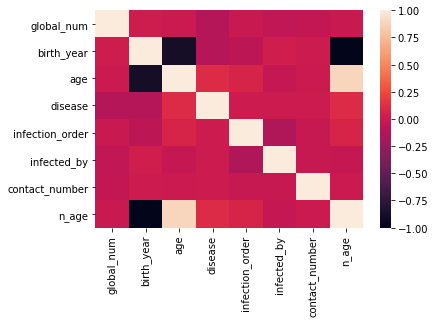

In [276]:
# this is only going to work for numeric features - and again I wish there were a data dictionary!

heatvars = ['global_num', 'birth_year', 'age', 'disease', 'infection_order', 'infected_by', 'contact_number', 'n_age']
_ = sns.heatmap(df[heatvars].corr())


Well, that's not terribly informative, really.  The only strong correlations we see are between age, n_age, and birth_year; this is of course no surprise at all.  It looks like disease doesn't correlate strongly with anything, except perhaps these age-related variables.

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

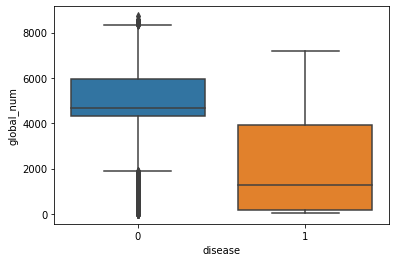

In [286]:
# plotting the appropriate variables in a single boxplot is utterly non-informative because of the difference in scale.
# and what do we want to check for here, precisely?
# fig, axes = plt.subplots(2,3)
#sns.boxplot(ax=axes[0], x='disease', y='global_num', data=df)
#sns.boxplot(ax=axes[1], x='disease', y='birth_year', data=df)
#sns.boxplot(ax=axes[2], x='disease', y='n_age', data=df)
#sns.boxplot(ax=axes[3], x='disease', y='infection_order', data=df)
#sns.boxplot(ax=axes[4], x='disease', y='infected_by', data=df)
#sns.boxplot(ax=axes[5], x='disease', y='contact_number', data=df)

_ = sns.boxplot(x='disease', y='global_num', data=df)


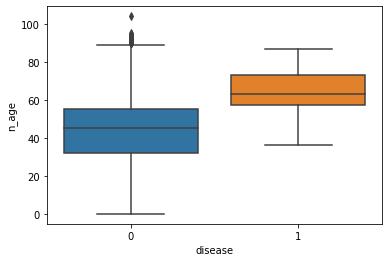

In [287]:
_ = sns.boxplot(x='disease', y='n_age', data=df)

<AxesSubplot:xlabel='disease', ylabel='contact_number'>

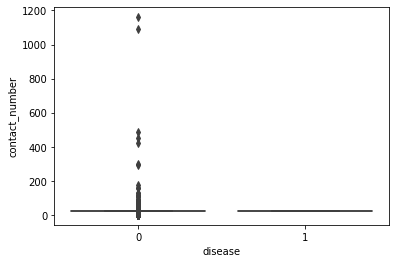

In [291]:
sns.boxplot(x='disease', y='contact_number', data=df)

These boxplots are mostly utterly unsatisfying.  I have no idea, for instance, what 'global_num' and 'contact_number' are.  The only thing that stands out is that the disease=1 observations correspond to a higher distribution of ages than the disease=0 do, but that's trivial.

**<font color='teal'> Create dummy features for object type features. </font>**

In [296]:
df = pd.get_dummies(df)


In [298]:
df.dtypes

patient_id                                 int64
global_num                               float64
birth_year                               float64
age                                      float64
disease                                    int64
                                          ...   
infection_case_gym facility in Sejong      uint8
infection_case_overseas inflow             uint8
state_deceased                             uint8
state_isolated                             uint8
state_released                             uint8
Length: 185, dtype: object

In [299]:
dummies = df.select_dtypes(include='uint8')
print(dummies.columns)

Index(['sex_female', 'sex_male', 'country_China', 'country_Korea',
       'country_Mongolia', 'country_Thailand', 'province_Busan',
       'province_Chungcheongbuk-do', 'province_Chungcheongnam-do',
       'province_Daegu',
       ...
       'infection_case_Shincheonji Church',
       'infection_case_Suyeong-gu Kindergarten',
       'infection_case_contact with patient', 'infection_case_etc',
       'infection_case_gym facility in Cheonan',
       'infection_case_gym facility in Sejong',
       'infection_case_overseas inflow', 'state_deceased', 'state_isolated',
       'state_released'],
      dtype='object', length=176)


In [301]:
# I'm just going to remove these columns and consider what's left.
df = df.select_dtypes(exclude='uint8')
print(df.columns)

Index(['patient_id', 'global_num', 'birth_year', 'age', 'disease',
       'infection_order', 'infected_by', 'contact_number', 'n_age'],
      dtype='object')


I don't see how 'patient_id' is likely to be any kind of useful predictor of anything.  I also don't see how including more than one of the 'birth_year', 'age', and 'n_age' variables is prudent; I'll go with 'n_age'.  I'm not sure what 'infection_order', 'infected_by', and 'contact_number' mean exactly - again, I wish there were a data dictionary here!  But I'll include them and see what happens.

In [303]:
others = df[['global_num', 'infection_order', 'infected_by', 'contact_number', 'n_age']]
predictors = pd.concat([others, dummies], axis=1)
predictors.shape
predictors.head()

,global_num,infection_order,infected_by,contact_number,n_age,sex_female,sex_male,country_China,country_Korea,country_Mongolia,...,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow,state_deceased,state_isolated,state_released
0,2.0,1.0,2.600789e+09,75.0,56.0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1,5.0,1.0,2.600789e+09,31.0,33.0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,1
2,6.0,2.0,2.002000e+09,17.0,56.0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,7.0,1.0,2.600789e+09,9.0,29.0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,1
4,9.0,2.0,1.000000e+09,2.0,28.0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1


### Split the data into test and train subsamples

In [304]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y
# THIS WAS HARD with so many indicator variables
X = predictors
y = df['disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [305]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [306]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [307]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.993
Random Forest: f1-score=0.991


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [308]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[440   0]
 [  3   1]]
Normalized confusion matrix
[[1.   0.  ]
 [0.75 0.25]]


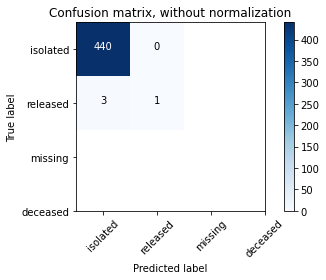

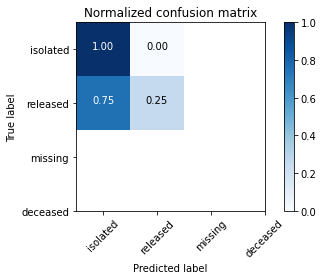

In [309]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


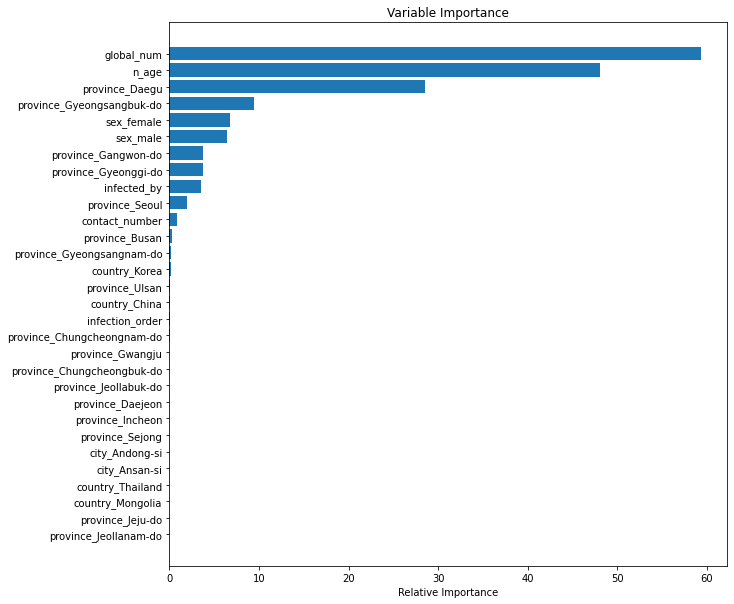

In [310]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.

Honestly, I have little understanding of what the last code blocks did, nor indeed how to interpret them for the most part.  This case study would have been far, far better if it had involved more coding toward the end.